In [ ]:
#Import required libraries
import string
import statistics
import re
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate import bleu_score
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections
#matplotlib inline
pd.set_option('display.max_colwidth', 200)

from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install rouge
from rouge import Rouge

# German Models

## German Preprocessing

In [ ]:
#Make sure this file is uploaded to your Google Drive in the same 
#folder as this notebook.
german_path = 'deu_short.txt'
#Data source:
#http://www.manythings.org/anki/

In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [ ]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
#load German data
data = read_text(german_path)
deu_eng = to_lines(data)
deu_eng = array(deu_eng)


In [ ]:
#get manageable sample
deu_eng = deu_eng[:10000,:]

In [ ]:
#Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('','', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('','', string.punctuation)) for s in deu_eng[:,1]]

In [ ]:
#Convert to lowercase.
for i in range(len(deu_eng)):
    deu_eng[i,0]=deu_eng[i,0].lower()
    deu_eng[i,1]=deu_eng[i,1].lower()

In [ ]:
#Analyze vocabulary of German dataset.
german_words_counter = collections.Counter([word for sentence in deu_eng[:,1] for word in sentence.split()])
english_words_counter_de = collections.Counter([word for sentence in deu_eng[:,0] for word in sentence.split()])
print('{} English words/tokens in English-German corpus, sample'.format(len([word for sentence in deu_eng[:,0]
                                                                     for word in sentence.split()])))
print('{} unique English words/tokens in English-German corpus, sample'.format(len(english_words_counter_de)))
print('10 most common English word in the English-German sample corpus, stop words included:')
print('""'+'" "'.join(list(zip(*english_words_counter_de.most_common(10)))[0])+'"')
print('{} German words/tokens in English-German sample corpus'.format(len([word for sentence in deu_eng[:,1] 
                                                                   for word in sentence.split()])))
print('{} unique German words/tokens in English-German sample corpus'.format(len(german_words_counter)))
print('10 most common German words in the English-German sample corpus, stop words included:')
print('"'+'" "'.join(list(zip(*german_words_counter.most_common(10)))[0])+'"')

28171 English words/tokens in English-German corpus, sample
2276 unique English words/tokens in English-German corpus, sample
10 most common English word in the English-German sample corpus, stop words included:
""tom" "i" "it" "is" "you" "a" "im" "me" "its" "he"
33356 German words/tokens in English-German sample corpus
3646 unique German words/tokens in English-German sample corpus
10 most common German words in the English-German sample corpus, stop words included:
"ich" "tom" "ist" "sie" "es" "das" "bin" "nicht" "wir" "hat"


In [ ]:
#create empty lists
eng_l = []
deu_l = []
#populate lists w/ sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))
for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [ ]:
#Display descriptive statistics for English and German sentence lengths
df_eng_l_sample = pd.DataFrame(eng_l)
print(df_eng_l_sample.describe())
print("Average English sentence length in English-German sample corpus: ",statistics.mean(df_eng_l_sample.iloc[:,0]))

df_deu_l_sample = pd.DataFrame(deu_l)
print(df_deu_l_sample.describe())
print("Average German sentence length in English-German sample corpus: ", statistics.mean(df_deu_l_sample.iloc[:,0]))

                  0
count  10000.000000
mean       2.817100
std        0.658704
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Average English sentence length in English-German sample corpus:  2.8171
                  0
count  10000.000000
mean       3.335600
std        0.886031
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        9.000000
Average German sentence length in English-German sample corpus:  3.3356


In [ ]:
#create length dataframe
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

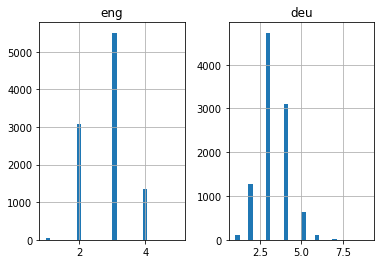

In [ ]:
#examine distribution of lengths
length_df.hist(bins=30)
plt.show()

In [ ]:
#define tokenizer-builder function
def tokenization(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
def max_length(lines):
	return max(len(line.split()) for line in lines)

In [ ]:
#prep english tokenizer for german translation
eng_de_tokenizer = tokenization(deu_eng[:,0])
#get english vocab size for german translation
eng_de_vocab_size = len(eng_de_tokenizer.word_index)+1
eng_length = max_length(deu_eng[:,0])
print("English vocabulary size: %d" % eng_de_vocab_size)

English vocabulary size: 2277


In [ ]:
#prepare german tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = max_length(deu_eng[:,1])
print('German Vocabulary Size: %d' % deu_vocab_size)

German Vocabulary Size: 3647


In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## German Baseline Model

In [ ]:
#Model 1: Code From 
#https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

In [ ]:
#Create training and test data.
trainDeu, testDeu = train_test_split(deu_eng, test_size=0.2, random_state=12)

In [ ]:
#prepare training data
trainGermanX = encode_sequences(deu_tokenizer, deu_length, trainDeu[:,1])
trainEnglishGermanY = encode_sequences(eng_de_tokenizer, eng_length, trainDeu[:,0])

In [ ]:
#prepare test data
testGermanX = encode_sequences(deu_tokenizer, deu_length, testDeu[:,1])
testEnglishGermanY=encode_sequences(eng_de_tokenizer, eng_length, testDeu[:,0])

In [ ]:
#build NMT model. This model is LSTM-based.
def build_model1(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
#Build and compile the model and define the optimizer.
model_de_1 = build_model1(deu_vocab_size, eng_de_vocab_size, deu_length, eng_length, 512)
model_de_1.summary()
rms_de_1 = optimizers.RMSprop(lr=0.001)
model_de_1.compile(optimizer=rms_de_1, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 9, 512)            1867264   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 5, 2277)           1168101   
Total params: 7,233,765
Trainable params: 7,233,765
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fit the model and save it so we do not have to run this entire block 
#of code again later, because that takes far too long.
filename_de_1 = 'model.h1.1_may_21_model1'
checkpoint_de_1 = ModelCheckpoint(filename_de_1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_de_1 = model_de_1.fit(trainGermanX, trainEnglishGermanY.reshape(trainEnglishGermanY.shape[0], trainEnglishGermanY.shape[1],1),
                      epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoint_de_1], verbose =1)

Epoch 1/30
13/13 [==============================] - 38s 190ms/step - loss: 6.1435 - accuracy: 0.3356 - val_loss: 3.9788 - val_accuracy: 0.4576

Epoch 00001: val_loss improved from inf to 3.97878, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 2/30
13/13 [==============================] - 1s 56ms/step - loss: 3.7958 - accuracy: 0.4583 - val_loss: 3.5635 - val_accuracy: 0.4676

Epoch 00002: val_loss improved from 3.97878 to 3.56348, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 3/30
13/13 [==============================] - 1s 58ms/step - loss: 3.4129 - accuracy: 0.4707 - val_loss: 3.3533 - val_accuracy: 0.4794

Epoch 00003: val_loss improved from 3.56348 to 3.35333, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 4/30
13/13 [==============================] - 1s 54ms/step - loss: 3.2507 - accuracy: 0.4799 - val_loss: 3.3187 - val_accuracy: 0.4810

Epoch 00004: val_loss improved from 3.35333 to 3.31865, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 5/30
13/13 [==============================] - 1s 54ms/step - loss: 3.1595 - accuracy: 0.4860 - val_loss: 3.2769 - val_accuracy: 0.4824

Epoch 00005: val_loss improved from 3.31865 to 3.27694, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 6/30
13/13 [==============================] - 1s 55ms/step - loss: 3.1293 - accuracy: 0.4896 - val_loss: 3.2683 - val_accuracy: 0.4820

Epoch 00006: val_loss improved from 3.27694 to 3.26830, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 7/30
13/13 [==============================] - 1s 53ms/step - loss: 3.0559 - accuracy: 0.5000 - val_loss: 3.2025 - val_accuracy: 0.5033

Epoch 00007: val_loss improved from 3.26830 to 3.20249, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 8/30
13/13 [==============================] - 1s 53ms/step - loss: 2.9644 - accuracy: 0.5110 - val_loss: 3.1626 - val_accuracy: 0.5085

Epoch 00008: val_loss improved from 3.20249 to 3.16263, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 9/30
13/13 [==============================] - 1s 55ms/step - loss: 2.8714 - accuracy: 0.5229 - val_loss: 3.1104 - val_accuracy: 0.5180

Epoch 00009: val_loss improved from 3.16263 to 3.11036, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 10/30
13/13 [==============================] - 1s 55ms/step - loss: 2.7945 - accuracy: 0.5306 - val_loss: 3.1191 - val_accuracy: 0.5228

Epoch 00010: val_loss did not improve from 3.11036
Epoch 11/30
13/13 [==============================] - 1s 46ms/step - loss: 2.7139 - accuracy: 0.5421 - val_loss: 2.9638 - val_accuracy: 0.5315

Epoch 00011: val_loss improved from 3.11036 to 2.96384, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 12/30
13/13 [==============================] - 1s 56ms/step - loss: 2.6022 - accuracy: 0.5493 - val_loss: 2.9678 - val_accuracy: 0.5408

Epoch 00012: val_loss did not improve from 2.96384
Epoch 13/30
13/13 [==============================] - 1s 45ms/step - loss: 2.5560 - accuracy: 0.5515 - val_loss: 2.8924 - val_accuracy: 0.5447

Epoch 00013: val_loss improved from 2.96384 to 2.89235, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 14/30
13/13 [==============================] - 1s 55ms/step - loss: 2.4628 - accuracy: 0.5649 - val_loss: 2.8892 - val_accuracy: 0.5510

Epoch 00014: val_loss improved from 2.89235 to 2.88916, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 15/30
13/13 [==============================] - 1s 54ms/step - loss: 2.3949 - accuracy: 0.5708 - val_loss: 2.8182 - val_accuracy: 0.5573

Epoch 00015: val_loss improved from 2.88916 to 2.81822, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 16/30
13/13 [==============================] - 1s 53ms/step - loss: 2.3059 - accuracy: 0.5804 - val_loss: 2.8249 - val_accuracy: 0.5589

Epoch 00016: val_loss did not improve from 2.81822
Epoch 17/30
13/13 [==============================] - 1s 46ms/step - loss: 2.2541 - accuracy: 0.5865 - val_loss: 2.8229 - val_accuracy: 0.5601

Epoch 00017: val_loss did not improve from 2.81822
Epoch 18/30
13/13 [==============================] - 1s 46ms/step - loss: 2.1881 - accuracy: 0.5920 - val_loss: 2.7773 - val_accuracy: 0.5635

Epoch 00018: val_loss improved from 2.81822 to 2.77726, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 19/30
13/13 [==============================] - 1s 55ms/step - loss: 2.1418 - accuracy: 0.5981 - val_loss: 2.7529 - val_accuracy: 0.5684

Epoch 00019: val_loss improved from 2.77726 to 2.75287, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 20/30
13/13 [==============================] - 1s 52ms/step - loss: 2.0674 - accuracy: 0.6038 - val_loss: 2.7258 - val_accuracy: 0.5734

Epoch 00020: val_loss improved from 2.75287 to 2.72583, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 21/30
13/13 [==============================] - 1s 53ms/step - loss: 2.0209 - accuracy: 0.6053 - val_loss: 2.7074 - val_accuracy: 0.5742

Epoch 00021: val_loss improved from 2.72583 to 2.70741, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 22/30
13/13 [==============================] - 1s 53ms/step - loss: 1.9733 - accuracy: 0.6147 - val_loss: 2.7142 - val_accuracy: 0.5719

Epoch 00022: val_loss did not improve from 2.70741
Epoch 23/30
13/13 [==============================] - 1s 47ms/step - loss: 1.9355 - accuracy: 0.6124 - val_loss: 2.6367 - val_accuracy: 0.5845

Epoch 00023: val_loss improved from 2.70741 to 2.63666, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 24/30
13/13 [==============================] - 1s 55ms/step - loss: 1.8573 - accuracy: 0.6231 - val_loss: 2.6253 - val_accuracy: 0.5895

Epoch 00024: val_loss improved from 2.63666 to 2.62534, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 25/30
13/13 [==============================] - 1s 52ms/step - loss: 1.8015 - accuracy: 0.6334 - val_loss: 2.6230 - val_accuracy: 0.5886

Epoch 00025: val_loss improved from 2.62534 to 2.62299, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 26/30
13/13 [==============================] - 1s 51ms/step - loss: 1.7707 - accuracy: 0.6333 - val_loss: 2.6401 - val_accuracy: 0.5914

Epoch 00026: val_loss did not improve from 2.62299
Epoch 27/30
13/13 [==============================] - 1s 47ms/step - loss: 1.7361 - accuracy: 0.6392 - val_loss: 2.6283 - val_accuracy: 0.5879

Epoch 00027: val_loss did not improve from 2.62299
Epoch 28/30
13/13 [==============================] - 1s 46ms/step - loss: 1.6739 - accuracy: 0.6462 - val_loss: 2.6344 - val_accuracy: 0.5938

Epoch 00028: val_loss did not improve from 2.62299
Epoch 29/30
13/13 [==============================] - 1s 47ms/step - loss: 1.6518 - accuracy: 0.6480 - val_loss: 2.5858 - val_accuracy: 0.6014

Epoch 00029: val_loss improved from 2.62299 to 2.58576, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 30/30
13/13 [==============================] - 1s 54ms/step - loss: 1.6009 - accuracy: 0.6546 - val_loss: 2.5444 - val_accuracy: 0.6075

Epoch 00030: val_loss improved from 2.58576 to 2.54442, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


In [ ]:
#make predictions on the test data
model_de_pred_1 = load_model('model.h1.1_may_21_model1')
preds_de_1 = model_de_pred_1.predict_classes(testGermanX.reshape(testGermanX.shape[0], testGermanX.shape[1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#Define function to get a word from the tokenizer.
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
#Convert predictions into text (English)
preds_text_eng_de_1 = []
for i in preds_de_1:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_de_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_de_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if (t == None):
                temp.append('')
            else:
                temp.append(t)
    preds_text_eng_de_1.append(' '.join(temp))

In [ ]:
#Convert the predictions into a dataframe and display the first fifteen rows.
pred_df_de_1 = pd.DataFrame({'actual': testDeu[:,0], 'predicted': preds_text_eng_de_1})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df_de_1.head(15)

,actual,predicted
0,i love garlic,i like coffee
1,it was on sale,he has a
2,who are you,we are
3,is it for here,keep to me
4,send it to me,is it to
5,tom is loving,tom is
6,i was bullied,im not
7,tom got hacked,tom was
8,tom just ate,tom was me
9,tom saw me,tom was it


### German Baseline Model Metrics

In [ ]:
#Calculate German metrics: accuracy, precision, recall
y_pred_de_1 = model_de_1.predict_classes(testGermanX, verbose=0)
print(y_pred_de_1)
y_pred_de_1 = argmax(y_pred_de_1, axis=1)
print(y_pred_de_1)
y_test_de_1 = argmax(testEnglishGermanY, axis=1)
print(y_test_de_1)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_de_1, y_pred_de_1))
print("Precision:",metrics.precision_score(y_test_de_1, y_pred_de_1, average = "macro"))
print("Recall:",metrics.recall_score(y_test_de_1, y_pred_de_1, average = "macro"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[  2  33 293   0   0]
 [ 10  59   6   0   0]
 [ 13  18   0   0   0]
 ...
 [ 41   3   0   0   0]
 [  2  40   3   3   0]
 [ 10   4   0   0   0]]
[2 1 1 ... 0 1 0]
[2 3 0 ... 0 3 1]
Accuracy: 0.4635
Precision: 0.4463172676770609
Recall: 0.3179522171281914


In [ ]:
#Training accuracy
metricsModelDe1 = model_de_1.evaluate(trainGermanX, trainEnglishGermanY, batch_size=512, return_dict=True)
print(metricsModelDe1)

16/16 [==============================] - 2s 19ms/step - loss: 1.7164 - accuracy: 0.6562
{'loss': 1.7163742780685425, 'accuracy': 0.6562250256538391}


In [ ]:
#Test accuracy
_, accuracy = model_de_1.evaluate(testGermanX, testEnglishGermanY, batch_size=512)
print('Test accuracy: %.2f' % (accuracy*100))

4/4 [==============================] - 0s 16ms/step - loss: 2.5876 - accuracy: 0.6082
Test accuracy: 60.82


In [ ]:
# calculate bleu metric

references_de_1 = pred_df_de_1.actual
candidates_de_1 = pred_df_de_1.predicted
score_de_1 = corpus_bleu(references_de_1, candidates_de_1, weights=(1,0,0,0))
print(score_de_1)

0.448643903340572


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
#average BLEU score
from statistics import mean

def evaluate_test_model1(references, hypothesis):
  bleuScores = []
  for i in range(len(references)):
    bleuScore = bleu_score.sentence_bleu(references[i], hypothesis[i], weights=(0.5, 0.5))
    bleuScores.append(bleuScore)
    bleuScoreMean = mean(bleuScores)
    return bleuScoreMean
bleuScoreMeanDeu1 = evaluate_test_model1(references_de_1, candidates_de_1)


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Average BLEU score on test data for German model 1: ", bleuScoreMeanDeu1)

Average BLEU score on test data for German model 1:  0.6324555320336759


In [ ]:
#Get ROUGE scores.
rouge = Rouge()
scores_de_1 = rouge.get_scores(candidates_de_1, references_de_1, avg = True)
print(scores_de_1)

{'rouge-1': {'f': 0.3543904727903922, 'p': 0.40383333333333354, 'r': 0.3248333333333337}, 'rouge-2': {'f': 0.09814999923764693, 'p': 0.12833333333333335, 'r': 0.08308333333333333}, 'rouge-l': {'f': 0.3542285680297718, 'p': 0.40425000000000016, 'r': 0.32433333333333364}}


## German Final Model

In [ ]:
#Model 2: An attempt at an encoder-decoder model. uses average BLEU as metric.
#Source: https://medium.com/analytics-vidhya/seq2seq-models-french-to-english-translation-using-encoder-decoder-model-with-attention-9c05b2c09af8
import unicodedata
import io
from tqdm import tqdm
from numpy.random import shuffle
def unicode_to_ascii(s) :
  """
  Unicode to ascii conversion
  """
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
def cleanString(incomingString):
  """
  Function to clean unwanted symbol from text
  """
  newstring = incomingString
  newstring = newstring.replace("!","")
  newstring = newstring.replace("@","")
  newstring = newstring.replace("#","")
  newstring = newstring.replace("$","")
  newstring = newstring.replace("%","")
  newstring = newstring.replace("^","")
  newstring = newstring.replace("&","and")
  newstring = newstring.replace("*","")
  newstring = newstring.replace("(","")
  newstring = newstring.replace(")","")
  newstring = newstring.replace("+","")
  newstring = newstring.replace("=","")
  newstring = newstring.replace("?","")
  newstring = newstring.replace("\'","")
  newstring = newstring.replace("\"","")
  newstring = newstring.replace("{","")
  newstring = newstring.replace("}","")
  newstring = newstring.replace("[","")
  newstring = newstring.replace("]","")
  newstring = newstring.replace("<","")
  newstring = newstring.replace(">","")
  newstring = newstring.replace("~","")
  newstring = newstring.replace("`","")
  newstring = newstring.replace(":","")
  newstring = newstring.replace(";","")
  newstring = newstring.replace("|","")
  newstring = newstring.replace("\\","")
  newstring = newstring.replace("/","")     
  return ' '.join(newstring.split())
def preprocess_string(data) :
  """
  This function calls other
  preprocessing function for
  cleaning data
  """
  data = unicode_to_ascii(data)
  
  #Remove unwanted symbols
  data = cleanString(data)
  return data

lines_de = io.open(german_path, encoding = 'UTF-8').read().split('\n')



In [ ]:
def get_data(raw_lines) :
  lang_a = []
  english = []
  for itr in tqdm(range(len(raw_lines))) :
    if len(raw_lines[itr].split()) > 2 :
      eng, langa, _ = raw_lines[itr].split('\t')
      english.append('<start> ' + preprocess_string(eng) + ' <end>')
      lang_a.append('<start> ' + preprocess_string(langa) + ' <end>')
  return lang_a, english
  
#Get data
german, english = get_data(lines_de)
#get manageable sample
german = german[:10000:]
#get manageable sample
english = english[:10000:]
print(german[0:10])

100%|██████████| 227081/227081 [00:06<00:00, 33956.57it/s]

['<start> Geh. <end>', '<start> Hallo <end>', '<start> Gruß Gott <end>', '<start> Lauf <end>', '<start> Lauf <end>', '<start> Potzdonner <end>', '<start> Donnerwetter <end>', '<start> Feuer <end>', '<start> Hilfe <end>', '<start> Zu Hulf <end>']


In [ ]:
#Define the train-test split
deu_tr, deu_te, eng_tr, eng_te = train_test_split(german, english, test_size = 0.2, random_state = 42)

In [ ]:
#Tokenizing, padding input language
deu_token = Tokenizer(filters = '', lower=False)
deu_token.fit_on_texts(deu_tr)
deu_tokenized = deu_token.texts_to_sequences(deu_tr)
deu_padded = pad_sequences(deu_tokenized, padding='post')

In [ ]:
#tokenizing and padding target language
eng_token = Tokenizer(filters = '', lower = False)
eng_token.fit_on_texts(eng_tr)
eng_tokenized = eng_token.texts_to_sequences(eng_tr)
eng_padded = pad_sequences(eng_tokenized, padding='post')

In [ ]:
#find the vocabulary size and maximum sentence length
num_ip_tokens = len(deu_token.word_index) #German
num_op_tokens = len(eng_token.word_index) #English
max_len_ip = deu_padded.shape[1] #German
max_len_op = eng_padded.shape[1] #English


In [ ]:
#Define constants and create a tf.data dataset of language data.
import tensorflow as tf

BUFFER_SIZE = len(deu_padded)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 256
units = 512

dataset_de = tf.data.Dataset.from_tensor_slices((deu_padded, eng_padded)).shuffle(BUFFER_SIZE)
dataset_de = dataset_de.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:

#This function will return CuDNNGRU if GPU is available for faster execution
def gru(units):
    # If you have a GPU, i recommend using CuDNNGRU(provides a 3x speedup than GRU)
    # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform',
                                  recurrent_activation='sigmoid')
     
#Encoder architecture :
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state
    def initial_hidden_state(self):
        #Generating encoder initial states as all zeros
        return tf.zeros((self.batch_sz, self.enc_units))
   
#Decoder with attention
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        #Getting scores
        score = self.V(tf.nn.tanh(self.W1(enc_output)+self.W2(hidden_with_time_axis)))
        # attention_weights shape == (batch_size, max_length, 1)
        #Attention weights from softmax
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        #getting context vector
        context_vector = attention_weights*enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        #Concatenating previous op with cv
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return tf.zeros(self.batch_sz, self.dec_units)
#Define an encoder and decoder.  
encoder = Encoder(num_ip_tokens + 1, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(num_op_tokens + 1, embedding_dim, units, BATCH_SIZE)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
#Define an optimizer.
optimizer_de = tf.keras.optimizers.Adam()
#Define a loss function.
def loss_function_de(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred)*mask
  return tf.reduce_mean(loss_)
#Define the checkpoint used to save
import os
from tensorflow.train import Checkpoint
checkpoint_dir_de = '/content/drive/MyDrive/GermanToEnglish/CheckPoint'
checkpoint_prefix_de = os.path.join(checkpoint_dir_de, 'ckpt')
checkpoint_de = Checkpoint(optimizer=optimizer_de, encoder=encoder, decoder=decoder)

In [ ]:
#train model
import numpy as np
import time
EPOCH = 20
for epoch in range(EPOCH) :
  start = time.time()
  #Getting initial encoder states (all zeros)
  hidden = encoder.initial_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset_de) :
    loss = 0
    with tf.GradientTape() as tape :
      enc_output , enc_hidden = encoder(inp, hidden)
      #Setting final encoder states as initial decoder states
      dec_hidden = enc_hidden
      # Teacher forcing - feeding the target as the next input
      #Passing '<start>' token as initial token
      dec_input = tf.expand_dims([eng_token.word_index['<start>']]*BATCH_SIZE, 1)
      for t in range(1, targ.shape[1]) :
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function_de(targ[:,t], predictions)
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:,t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    total_loss += batch_loss        
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)
    optimizer_de.apply_gradients(zip(gradients, variables))
    if batch % 1000 == 0 :
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint)  the model every 2 epochs
  if (epoch + 1)%2 == 0 :
    checkpoint_de.save(file_prefix=checkpoint_prefix_de)
  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
  print('Time taken for 1 epoch {0:0.2f} minutes\n'.format((time.time() - start)/60))

Epoch 1 Batch 0 Loss 4.2699
Epoch 1 Loss 2.7049
Time taken for 1 epoch 0.29 minutes

Epoch 2 Batch 0 Loss 2.2097
Epoch 2 Loss 2.0931
Time taken for 1 epoch 0.29 minutes

Epoch 3 Batch 0 Loss 1.9003
Epoch 3 Loss 1.8130
Time taken for 1 epoch 0.29 minutes

Epoch 4 Batch 0 Loss 1.6486
Epoch 4 Loss 1.5731
Time taken for 1 epoch 0.29 minutes

Epoch 5 Batch 0 Loss 1.5141
Epoch 5 Loss 1.3524
Time taken for 1 epoch 0.29 minutes

Epoch 6 Batch 0 Loss 1.2033
Epoch 6 Loss 1.1538
Time taken for 1 epoch 0.29 minutes

Epoch 7 Batch 0 Loss 0.9708
Epoch 7 Loss 0.9827
Time taken for 1 epoch 0.29 minutes

Epoch 8 Batch 0 Loss 0.7792
Epoch 8 Loss 0.8275
Time taken for 1 epoch 0.29 minutes

Epoch 9 Batch 0 Loss 0.6931
Epoch 9 Loss 0.6931
Time taken for 1 epoch 0.29 minutes

Epoch 10 Batch 0 Loss 0.5774
Epoch 10 Loss 0.5723
Time taken for 1 epoch 0.29 minutes

Epoch 11 Batch 0 Loss 0.4010
Epoch 11 Loss 0.4718
Time taken for 1 epoch 0.28 minutes

Epoch 12 Batch 0 Loss 0.3571
Epoch 12 Loss 0.3862
Time taken 

### German Final Model Metrics

In [ ]:
#Evaluate model
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    #attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_string(sentence)
    inputs = []
    for w in sentence.split(' ') :
      if w in inp_lang.word_index.keys() :
        inputs.append(inp_lang.word_index[w])
    
    #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1,units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        #attention_weights = tf.reshape(attention_weights, (-1, ))
        #attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence
  


    
def translate(sentence, eng_sen, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    #print('Input: {}'.format(sentence))
    #print('Actual translation: {}'.format(eng_sen))
    #print('Predicted translation: {}'.format(result[:-7]))
    bleu = bleu_score.sentence_bleu(eng_sen, result[:-7], weights=(0.5, 0.5))
    #print("BLEU Score : {0:0.2f}".format(bleu_score.sentence_bleu(eng_sen, result[:-7], weights=(0.5, 0.5))))
    return bleu, result[:-7]
    #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    #plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    #plt.show()

In [ ]:
#define function for average BLEU score
from statistics import mean
def evaluate_test_model2(testDataX, testDataY, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
  bleuScores = []
  references = []
  hypotheses = []
  for i in range(len(testDataX)):
    bleuScore, hypothesis = translate(testDataX[i], testDataY[i], encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    bleuScores.append(bleuScore)
    references.append(testDataY[i])
    hypotheses.append(hypothesis)
  bleuScoreMean = mean(bleuScores)
  return bleuScoreMean, references, hypotheses


In [ ]:
#get average BLEU score
bleuScoreMeanDeu, referencesDe2, hypothesesDe2 = evaluate_test_model2(deu_te, eng_te, encoder, decoder, deu_token, eng_token, max_len_ip, max_len_op)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Average BLEU score on test data for German model 2: ", bleuScoreMeanDeu)

Average BLEU score on test data for German model 2:  0.766439849896392


In [ ]:
# Filter out hyps of 0 length
hyps_and_refs = zip(hypothesesDe2, referencesDe2)
hyps_and_refs = [ _ for _ in hyps_and_refs if len(_[0]) > 0]
hypothesesDe2, referencesDe2 = zip(*hyps_and_refs)

In [ ]:
#Get ROUGE scores.
rouge = Rouge()
scores_de_2 = rouge.get_scores(hypothesesDe2, referencesDe2, avg = True)
print(scores_de_2)

{'rouge-1': {'f': 0.1786756551527325, 'p': 0.25935672514619856, 'r': 0.1399916457811185}, 'rouge-2': {'f': 0.05328917470467728, 'p': 0.08120300751879697, 'r': 0.04034252297410197}, 'rouge-l': {'f': 0.17931574745787113, 'p': 0.2628654970760231, 'r': 0.13982456140350782}}


# Italian Models

## Italian Preprocessing

In [ ]:
#Make sure this file is uploaded to your Google Drive in the same 
#folder as this notebook.
italian_path = '/content/gdrive/MyDrive/ita_short.txt'

In [ ]:
#load Italian data
data = read_text(italian_path)
ita_eng = to_lines(data)
ita_eng = array(ita_eng)

In [ ]:
#get manageable sample
ita_eng = ita_eng[:10000,:]

In [ ]:
#Remove punctuation
ita_eng[:,0] = [s.translate(str.maketrans('','', string.punctuation)) for s in ita_eng[:,0]]
ita_eng[:,1] = [s.translate(str.maketrans('','', string.punctuation)) for s in ita_eng[:,1]]

In [ ]:
#Convert to lowercase.
for i in range(len(ita_eng)):
    ita_eng[i,0]=ita_eng[i,0].lower()
    ita_eng[i,1]=ita_eng[i,1].lower()

In [ ]:
#Analyze vocabulary of Italian dataset.
italian_words_counter = collections.Counter([word for sentence in ita_eng[:,1] for word in sentence.split()])
english_words_counter_ita = collections.Counter([word for sentence in ita_eng[:,0] for word in sentence.split()])
print('{} English words/tokens in English-Italian corpus, sample'.format(len([word for sentence in ita_eng[:,0]
                                                                     for word in sentence.split()])))
print('{} unique English words/tokens in English-Italian corpus, sample'.format(len(english_words_counter_ita)))
print('10 most common English word in the English-Italian sample corpus, stop words included:')
print('""'+'" "'.join(list(zip(*english_words_counter_ita.most_common(10)))[0])+'"')
print('{} Italian words/tokens in English-Italian sample corpus'.format(len([word for sentence in ita_eng[:,1] 
                                                                   for word in sentence.split()])))
print('{} unique Italian words/tokens in English-Italian sample corpus'.format(len(italian_words_counter)))
print('10 most common Italian words in the English-Italian sample corpus, stop words included:')
print('"'+'" "'.join(list(zip(*italian_words_counter.most_common(10)))[0])+'"')

24736 English words/tokens in English-Italian corpus, sample
1415 unique English words/tokens in English-Italian corpus, sample
10 most common English word in the English-Italian sample corpus, stop words included:
""i" "im" "tom" "it" "you" "is" "a" "me" "was" "we"
26023 Italian words/tokens in English-Italian sample corpus
3665 unique Italian words/tokens in English-Italian sample corpus
10 most common Italian words in the English-Italian sample corpus, stop words included:
"sono" "io" "è" "tom" "mi" "a" "ho" "non" "la" "di"


In [ ]:
#create empty lists
eng_l_ita_sample = []
ita_l_sample = []
#populate lists w/ sentence lengths
for i in ita_eng[:,0]:
    eng_l_ita_sample.append(len(i.split()))
for i in ita_eng[:,1]:
    ita_l_sample.append(len(i.split()))

In [ ]:
#Display descriptive statistics for English and French sentence lengths
df_eng_ita_l_sample = pd.DataFrame(eng_l_ita_sample)
print(df_eng_ita_l_sample.describe())
print("Average English sentence length in English-Italian sample corpus: ",statistics.mean(df_eng_ita_l_sample.iloc[:,0]))

df_ita_l_sample = pd.DataFrame(ita_l_sample)
print(df_ita_l_sample.describe())
print("Average Italian sentence length in English-Italian sample corpus: ", statistics.mean(df_ita_l_sample.iloc[:,0]))

                  0
count  10000.000000
mean       2.473600
std        0.559227
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Average English sentence length in English-Italian sample corpus:  2.4736
                  0
count  10000.000000
mean       2.602300
std        0.918705
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        7.000000
Average Italian sentence length in English-Italian sample corpus:  2.6023


In [ ]:
#create length dataframe
length_df_ita_sample = pd.DataFrame({'eng':eng_l_ita_sample, 'ital':ita_l_sample})

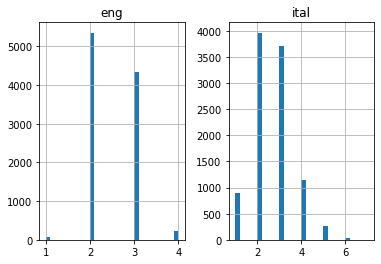

In [ ]:
#examine distribution of lengths
length_df_ita_sample.hist(bins=30)
plt.show()

In [ ]:
#prep english tokenizer for italian translation
eng_it_tokenizer = tokenization(ita_eng[:,0])
#get english vocab size for italian translation
eng_it_vocab_size = len(eng_it_tokenizer.word_index)+1
eng_it_length = max_length(ita_eng[:,0])
print("English vocabulary size: %d" % eng_it_vocab_size)

English vocabulary size: 1416


In [ ]:
#prepare italian tokenizer
ita_tokenizer = tokenization(ita_eng[:, 1])
ita_vocab_size = len(ita_tokenizer.word_index) + 1

ita_length = max_length(ita_eng[:,1])
print('Italian Vocabulary Size: %d' % ita_vocab_size)

Italian Vocabulary Size: 3666


## Italian Baseline Model

In [ ]:
#Get training, test data
trainIta, testIta = train_test_split(ita_eng, test_size=0.2, random_state=12)

In [ ]:
#prepare training data
trainItalianX = encode_sequences(ita_tokenizer, ita_length, trainIta[:,1])
trainEnglishItalianY = encode_sequences(eng_it_tokenizer, eng_it_length, trainIta[:,0])

In [ ]:
#prepare test data
testItalianX = encode_sequences(ita_tokenizer, ita_length, testIta[:,1])
testEnglishItalianY=encode_sequences(eng_it_tokenizer, eng_it_length, testIta[:,0])

In [ ]:
#Build model
model_it_1 = build_model1(ita_vocab_size, eng_it_vocab_size, ita_length, eng_it_length, 512)
model_it_1.summary()
rms_it_1 = optimizers.RMSprop(lr=0.001)
model_it_1.compile(optimizer=rms_it_1, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 7, 512)            1876992   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 512)            2099200   
_________________________________________________________________
dense_5 (Dense)              (None, 4, 1416)           726408    
Total params: 6,801,800
Trainable params: 6,801,800
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train model and save
filename_it_1 = 'model.h1.1_may_21_model1'
checkpoint_it_1 = ModelCheckpoint(filename_it_1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_it_1 = model_it_1.fit(trainItalianX, trainEnglishItalianY.reshape(trainEnglishItalianY.shape[0], trainEnglishItalianY.shape[1],1),
                      epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoint_it_1], verbose =1)

Epoch 1/30
13/13 [==============================] - 6s 158ms/step - loss: 6.1473 - accuracy: 0.2926 - val_loss: 4.2615 - val_accuracy: 0.3989

Epoch 00001: val_loss improved from inf to 4.26149, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 2/30
13/13 [==============================] - 1s 50ms/step - loss: 4.0550 - accuracy: 0.4102 - val_loss: 3.7933 - val_accuracy: 0.4306

Epoch 00002: val_loss improved from 4.26149 to 3.79325, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 3/30
13/13 [==============================] - 1s 49ms/step - loss: 3.5935 - accuracy: 0.4358 - val_loss: 3.5797 - val_accuracy: 0.4333

Epoch 00003: val_loss improved from 3.79325 to 3.57972, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 4/30
13/13 [==============================] - 1s 48ms/step - loss: 3.4133 - accuracy: 0.4386 - val_loss: 3.5289 - val_accuracy: 0.4320

Epoch 00004: val_loss improved from 3.57972 to 3.52893, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 5/30
13/13 [==============================] - 1s 49ms/step - loss: 3.3222 - accuracy: 0.4402 - val_loss: 3.4208 - val_accuracy: 0.4408

Epoch 00005: val_loss improved from 3.52893 to 3.42077, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 6/30
13/13 [==============================] - 1s 53ms/step - loss: 3.2214 - accuracy: 0.4513 - val_loss: 3.3284 - val_accuracy: 0.4430

Epoch 00006: val_loss improved from 3.42077 to 3.32844, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 7/30
13/13 [==============================] - 1s 49ms/step - loss: 3.1105 - accuracy: 0.4581 - val_loss: 3.1865 - val_accuracy: 0.4705

Epoch 00007: val_loss improved from 3.32844 to 3.18650, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 8/30
13/13 [==============================] - 1s 46ms/step - loss: 2.9741 - accuracy: 0.4781 - val_loss: 3.0858 - val_accuracy: 0.4812

Epoch 00008: val_loss improved from 3.18650 to 3.08578, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 9/30
13/13 [==============================] - 1s 46ms/step - loss: 2.8519 - accuracy: 0.4906 - val_loss: 2.9895 - val_accuracy: 0.4956

Epoch 00009: val_loss improved from 3.08578 to 2.98955, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 10/30
13/13 [==============================] - 1s 49ms/step - loss: 2.7367 - accuracy: 0.5048 - val_loss: 2.9150 - val_accuracy: 0.5081

Epoch 00010: val_loss improved from 2.98955 to 2.91502, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 11/30
13/13 [==============================] - 1s 46ms/step - loss: 2.6250 - accuracy: 0.5167 - val_loss: 2.8373 - val_accuracy: 0.5114

Epoch 00011: val_loss improved from 2.91502 to 2.83729, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 12/30
13/13 [==============================] - 1s 46ms/step - loss: 2.5201 - accuracy: 0.5272 - val_loss: 2.7815 - val_accuracy: 0.5202

Epoch 00012: val_loss improved from 2.83729 to 2.78152, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 13/30
13/13 [==============================] - 1s 47ms/step - loss: 2.4117 - accuracy: 0.5365 - val_loss: 2.7153 - val_accuracy: 0.5281

Epoch 00013: val_loss improved from 2.78152 to 2.71525, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 14/30
13/13 [==============================] - 1s 47ms/step - loss: 2.2936 - accuracy: 0.5514 - val_loss: 2.7257 - val_accuracy: 0.5277

Epoch 00014: val_loss did not improve from 2.71525
Epoch 15/30
13/13 [==============================] - 1s 41ms/step - loss: 2.2347 - accuracy: 0.5567 - val_loss: 2.6140 - val_accuracy: 0.5436

Epoch 00015: val_loss improved from 2.71525 to 2.61397, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 16/30
13/13 [==============================] - 1s 48ms/step - loss: 2.1507 - accuracy: 0.5670 - val_loss: 2.5454 - val_accuracy: 0.5536

Epoch 00016: val_loss improved from 2.61397 to 2.54536, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 17/30
13/13 [==============================] - 1s 48ms/step - loss: 2.0399 - accuracy: 0.5790 - val_loss: 2.5351 - val_accuracy: 0.5533

Epoch 00017: val_loss improved from 2.54536 to 2.53506, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 18/30
13/13 [==============================] - 1s 49ms/step - loss: 1.9735 - accuracy: 0.5888 - val_loss: 2.4694 - val_accuracy: 0.5642

Epoch 00018: val_loss improved from 2.53506 to 2.46939, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 19/30
13/13 [==============================] - 1s 51ms/step - loss: 1.8743 - accuracy: 0.6008 - val_loss: 2.4456 - val_accuracy: 0.5661

Epoch 00019: val_loss improved from 2.46939 to 2.44556, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 20/30
13/13 [==============================] - 1s 50ms/step - loss: 1.8059 - accuracy: 0.6101 - val_loss: 2.3713 - val_accuracy: 0.5811

Epoch 00020: val_loss improved from 2.44556 to 2.37130, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 21/30
13/13 [==============================] - 1s 51ms/step - loss: 1.7238 - accuracy: 0.6257 - val_loss: 2.3639 - val_accuracy: 0.5805

Epoch 00021: val_loss improved from 2.37130 to 2.36392, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 22/30
13/13 [==============================] - 1s 53ms/step - loss: 1.6513 - accuracy: 0.6342 - val_loss: 2.3058 - val_accuracy: 0.5903

Epoch 00022: val_loss improved from 2.36392 to 2.30581, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 23/30
13/13 [==============================] - 1s 49ms/step - loss: 1.5675 - accuracy: 0.6497 - val_loss: 2.2840 - val_accuracy: 0.5966

Epoch 00023: val_loss improved from 2.30581 to 2.28403, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 24/30
13/13 [==============================] - 1s 49ms/step - loss: 1.5189 - accuracy: 0.6561 - val_loss: 2.2266 - val_accuracy: 0.6044

Epoch 00024: val_loss improved from 2.28403 to 2.22657, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 25/30
13/13 [==============================] - 1s 48ms/step - loss: 1.4428 - accuracy: 0.6730 - val_loss: 2.2158 - val_accuracy: 0.6139

Epoch 00025: val_loss improved from 2.22657 to 2.21581, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 26/30
13/13 [==============================] - 1s 45ms/step - loss: 1.3810 - accuracy: 0.6843 - val_loss: 2.2019 - val_accuracy: 0.6066

Epoch 00026: val_loss improved from 2.21581 to 2.20194, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 27/30
13/13 [==============================] - 1s 46ms/step - loss: 1.3108 - accuracy: 0.6981 - val_loss: 2.1614 - val_accuracy: 0.6189

Epoch 00027: val_loss improved from 2.20194 to 2.16145, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 28/30
13/13 [==============================] - 1s 48ms/step - loss: 1.2602 - accuracy: 0.7095 - val_loss: 2.1460 - val_accuracy: 0.6203

Epoch 00028: val_loss improved from 2.16145 to 2.14597, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 29/30
13/13 [==============================] - 1s 47ms/step - loss: 1.1869 - accuracy: 0.7230 - val_loss: 2.1201 - val_accuracy: 0.6261

Epoch 00029: val_loss improved from 2.14597 to 2.12013, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 30/30
13/13 [==============================] - 1s 45ms/step - loss: 1.1323 - accuracy: 0.7365 - val_loss: 2.1155 - val_accuracy: 0.6280

Epoch 00030: val_loss improved from 2.12013 to 2.11547, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


In [ ]:
#make predictions on test data
model_it_pred_1 = load_model('model.h1.1_may_21_model1')
preds_it_1 = model_it_pred_1.predict_classes(testItalianX.reshape(testItalianX.shape[0], testItalianX.shape[1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#Convert predictions into text (English)
preds_text_eng_it_1 = []
for i in preds_it_1:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_it_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_it_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if (t == None):
                temp.append('')
            else:
                temp.append(t)
    preds_text_eng_it_1.append(' '.join(temp))

In [ ]:
#display first 15 predictions
pred_df_it_1 = pd.DataFrame({'actual': testIta[:,0], 'predicted': preds_text_eng_it_1})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df_it_1.head(15)

,actual,predicted
0,im worried,im am
1,im not dead,im not fat
2,im guilty,im biased
3,im for that,im in
4,tom is numb,tom is
5,what a drag,ill gave
6,its broken,he scary
7,stop whining,stop humming
8,he helps us,he gave
9,it stinks,it stink


### Italian Baseline Model Metrics

In [ ]:
#Calculate Italian metrics: accuracy, precision, recall
y_pred_it_1 = model_it_1.predict_classes(testItalianX, verbose=0)
print(y_pred_it_1)
y_pred_it_1 = argmax(y_pred_it_1, axis=1)
print(y_pred_it_1)
y_test_it_1 = argmax(testEnglishItalianY, axis=1)
print(y_test_it_1)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_it_1, y_pred_it_1))
print("Precision:",metrics.precision_score(y_test_it_1, y_pred_it_1, average = "macro"))
print("Recall:",metrics.recall_score(y_test_it_1, y_pred_it_1, average = "macro"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[  2  31   0   0]
 [  2  56  81   0]
 [  2 318   0   0]
 ...
 [ 24  47   0   0]
 [  1  38 334   0]
 [  1 115  29   0]]
[1 2 1 ... 1 2 1]
[1 2 1 ... 1 2 1]
Accuracy: 0.7155
Precision: 0.7295408483246758
Recall: 0.6040596369552188


In [ ]:
#Training accuracy
metricsModelIt1 = model_it_1.evaluate(trainItalianX, trainEnglishItalianY, batch_size=512, return_dict=True)
print(metricsModelIt1)

16/16 [==============================] - 2s 16ms/step - loss: 1.3109 - accuracy: 0.7149
{'loss': 1.310878038406372, 'accuracy': 0.7149062752723694}


In [ ]:
#Test accuracy
_, accuracy = model_it_1.evaluate(testItalianX, testEnglishItalianY, batch_size=512)
print('Test accuracy: %.2f' % (accuracy*100))

4/4 [==============================] - 0s 13ms/step - loss: 2.0687 - accuracy: 0.6396
Test accuracy: 63.96


In [ ]:
# calculate bleu metric

references_it_1 = pred_df_it_1.actual
candidates_it_1 = pred_df_it_1.predicted
score_it_1 = corpus_bleu(references_it_1, candidates_it_1, weights=(1,0,0,0))
print(score_it_1)

0.4897821150780231


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
#average BLEU score
bleuScoreMeanIta1 = evaluate_test_model1(references_it_1, candidates_it_1)


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Average BLEU score on test data for Italian model 1: ", bleuScoreMeanIta1)

Average BLEU score on test data for Italian model 1:  0.6546536707079771


In [ ]:
#Get ROUGE scores.
rouge = Rouge()
scores_it_1 = rouge.get_scores(candidates_it_1, references_it_1, avg = True)
print(scores_it_1)

{'rouge-1': {'f': 0.3543904727903922, 'p': 0.40383333333333354, 'r': 0.3248333333333337}, 'rouge-2': {'f': 0.09814999923764693, 'p': 0.12833333333333335, 'r': 0.08308333333333333}, 'rouge-l': {'f': 0.3542285680297718, 'p': 0.40425000000000016, 'r': 0.32433333333333364}}


## Italian Final Model

In [ ]:
#Model 2: An attempt at an encoder-decoder model. uses average BLEU as metric.
lines_it = io.open(italian_path, encoding = 'UTF-8').read().split('\n')

In [ ]:
#Get data
italian, english_it = get_data(lines_it)
#get manageable sample
italian = italian[:10000:]
#get manageable sample
english_it = english_it[:10000:]
print(italian[0:10])

100%|██████████| 345245/345245 [00:08<00:00, 38669.20it/s]

['<start> Ciao <end>', '<start> Corri <end>', '<start> Corra <end>', '<start> Correte <end>', '<start> Chi <end>', '<start> Wow <end>', '<start> Salta <end>', '<start> Salti <end>', '<start> Saltate <end>', '<start> Salta. <end>']


In [ ]:
#train-test split
ita_tr, ita_te, eng_it_tr, eng_it_te = train_test_split(italian, english_it, test_size = 0.2, random_state = 42)

In [ ]:
#Tokenizing, padding input language
ita_token = Tokenizer(filters = '', lower=False)
ita_token.fit_on_texts(ita_tr)
ita_tokenized = ita_token.texts_to_sequences(ita_tr)
ita_padded = pad_sequences(ita_tokenized, padding='post')

In [ ]:
#tokenizing and padding target language
eng_it_token = Tokenizer(filters = '', lower = False)
eng_it_token.fit_on_texts(eng_it_tr)
eng_it_tokenized = eng_it_token.texts_to_sequences(eng_it_tr)
eng_it_padded = pad_sequences(eng_it_tokenized, padding='post')

In [ ]:
#get vocab size, sequence length
num_ip_tokens = len(ita_token.word_index) #Italian
num_op_tokens = len(eng_it_token.word_index) #English
max_len_ip = ita_padded.shape[1] #Italian
max_len_op = eng_it_padded.shape[1] #English

In [ ]:
#Create tf.data dataset for Italian and set constants
BUFFER_SIZE = len(ita_padded)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 256
units = 512

dataset_it = tf.data.Dataset.from_tensor_slices((ita_padded, eng_it_padded)).shuffle(BUFFER_SIZE)
dataset_it = dataset_it.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
#Create encoder and decoder
encoder = Encoder(num_ip_tokens + 1, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(num_op_tokens + 1, embedding_dim, units, BATCH_SIZE)

In [ ]:
#Define optimizer and loss function for Italian
optimizer_it = tf.keras.optimizers.Adam()

def loss_function_it(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred)*mask
  return tf.reduce_mean(loss_)
#Create checkpoint for Italian
checkpoint_dir_it = '/content/drive/MyDrive/ItalianToEnglish/CheckPoint'
checkpoint_prefix_it = os.path.join(checkpoint_dir_it, 'ckpt')
checkpoint_it = Checkpoint(optimizer=optimizer_it, encoder=encoder, decoder=decoder)

In [ ]:
#Train Italian model
EPOCH = 20
for epoch in range(EPOCH) :
  start = time.time()
  #Getting initial encoder states (all zeros)
  hidden = encoder.initial_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset_it) :
    loss = 0
    with tf.GradientTape() as tape :
      enc_output , enc_hidden = encoder(inp, hidden)
      #Setting final encoder states as initial decoder states
      dec_hidden = enc_hidden
      # Teacher forcing - feeding the target as the next input
      #Passing '<start>' token as initial token
      dec_input = tf.expand_dims([eng_token.word_index['<start>']]*BATCH_SIZE, 1)
      for t in range(1, targ.shape[1]) :
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function_it(targ[:,t], predictions)
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:,t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    total_loss += batch_loss        
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)
    optimizer_it.apply_gradients(zip(gradients, variables))
    if batch % 1000 == 0 :
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint)  the model every 2 epochs
  if (epoch + 1)%2 == 0 :
    checkpoint_it.save(file_prefix=checkpoint_prefix_it)
  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
  print('Time taken for 1 epoch {0:0.2f} minutes\n'.format((time.time() - start)/60))

Epoch 1 Batch 0 Loss 4.4459
Epoch 1 Loss 2.6251
Time taken for 1 epoch 0.25 minutes

Epoch 2 Batch 0 Loss 2.1340
Epoch 2 Loss 2.0128
Time taken for 1 epoch 0.25 minutes

Epoch 3 Batch 0 Loss 1.7311
Epoch 3 Loss 1.7045
Time taken for 1 epoch 0.25 minutes

Epoch 4 Batch 0 Loss 1.6175
Epoch 4 Loss 1.4323
Time taken for 1 epoch 0.25 minutes

Epoch 5 Batch 0 Loss 1.2799
Epoch 5 Loss 1.2008
Time taken for 1 epoch 0.26 minutes

Epoch 6 Batch 0 Loss 1.0263
Epoch 6 Loss 0.9968
Time taken for 1 epoch 0.25 minutes

Epoch 7 Batch 0 Loss 0.8044
Epoch 7 Loss 0.8147
Time taken for 1 epoch 0.25 minutes

Epoch 8 Batch 0 Loss 0.6661
Epoch 8 Loss 0.6479
Time taken for 1 epoch 0.25 minutes

Epoch 9 Batch 0 Loss 0.4516
Epoch 9 Loss 0.5072
Time taken for 1 epoch 0.25 minutes

Epoch 10 Batch 0 Loss 0.3869
Epoch 10 Loss 0.3812
Time taken for 1 epoch 0.25 minutes

Epoch 11 Batch 0 Loss 0.2645
Epoch 11 Loss 0.2854
Time taken for 1 epoch 0.25 minutes

Epoch 12 Batch 0 Loss 0.2063
Epoch 12 Loss 0.2136
Time taken 

### Italian Final Model Metrics

In [ ]:
#Obtain average BLEU score for Italian on the test data
bleuScoreMeanIta, referencesIt2, hypothesesIt2 = evaluate_test_model2(ita_te, eng_it_te, encoder, decoder, ita_token, eng_it_token, max_len_ip, max_len_op)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Average BLEU score on test data for Italian model 2: ", bleuScoreMeanIta)

Average BLEU score on test data for Italian model 2:  0.792876516160249


In [ ]:
#Get ROUGE scores.
rouge = Rouge()
scores_it_2 = rouge.get_scores(hypothesesIt2, referencesIt2, avg = True)
print(scores_it_2)

{'rouge-1': {'f': 0.24195681536891792, 'p': 0.34045833333333336, 'r': 0.1899333333333319}, 'rouge-2': {'f': 0.0855357134836203, 'p': 0.14287500000000003, 'r': 0.06199999999999993}, 'rouge-l': {'f': 0.24251991061145184, 'p': 0.3425333333333333, 'r': 0.1899333333333319}}


# French Models

## French Preprocessing

In [ ]:
#Make sure this file is uploaded to your Google Drive in the same 
#folder as this notebook.
french_path = '/content/gdrive/MyDrive/fra.txt'

In [ ]:
#load French data
data = read_text(french_path)
fra_eng = to_lines(data)
fra_eng = array(fra_eng)

In [ ]:
#get manageable sample
fra_eng = fra_eng[:10000,:]

In [ ]:
#Remove punctuation
fra_eng[:,0] = [s.translate(str.maketrans('','', string.punctuation)) for s in fra_eng[:,0]]
fra_eng[:,1] = [s.translate(str.maketrans('','', string.punctuation)) for s in fra_eng[:,1]]

In [ ]:
#Convert to lowercase.
for i in range(len(fra_eng)):
    fra_eng[i,0]=fra_eng[i,0].lower()
    fra_eng[i,1]=fra_eng[i,1].lower()

In [ ]:
#Analyze vocabulary of French dataset.
french_words_counter = collections.Counter([word for sentence in fra_eng[:,1] for word in sentence.split()])
english_words_counter_fra = collections.Counter([word for sentence in fra_eng[:,0] for word in sentence.split()])
print('{} English words/tokens in English-French corpus, sample'.format(len([word for sentence in fra_eng[:,0]
                                                                     for word in sentence.split()])))
print('{} unique English words/tokens in English-French corpus, sample'.format(len(english_words_counter_fra)))
print('10 most common English word in the English-French sample corpus, stop words included:')
print('""'+'" "'.join(list(zip(*english_words_counter_fra.most_common(10)))[0])+'"')
print('{} French words/tokens in English-French sample corpus'.format(len([word for sentence in fra_eng[:,1] 
                                                                   for word in sentence.split()])))
print('{} unique French words/tokens in English-French sample corpus'.format(len(french_words_counter)))
print('10 most common French words in the English-French sample corpus, stop words included:')
print('"'+'" "'.join(list(zip(*french_words_counter.most_common(10)))[0])+'"')

27016 English words/tokens in English-French corpus, sample
2063 unique English words/tokens in English-French corpus, sample
10 most common English word in the English-French sample corpus, stop words included:
""i" "it" "tom" "you" "im" "a" "is" "me" "he" "go"
30576 French words/tokens in English-French sample corpus
4518 unique French words/tokens in English-French sample corpus
10 most common French words in the English-French sample corpus, stop words included:
"je" "tom" "suis" "nous" "il" "pas" "cest" "vous" "est" "jai"


In [ ]:
#create empty lists
eng_l_fra_sample = []
fra_l_sample = []
#populate lists w/ sentence lengths
for i in fra_eng[:,0]:
    eng_l_fra_sample.append(len(i.split()))
for i in fra_eng[:,1]:
    fra_l_sample.append(len(i.split()))

In [ ]:
#Display descriptive statistics for English and French sentence lengths
df_eng_fra_l_sample = pd.DataFrame(eng_l_fra_sample)
print(df_eng_fra_l_sample.describe())
print("Average English sentence length in English-French sample corpus: ",statistics.mean(df_eng_fra_l_sample.iloc[:,0]))

df_fra_l_sample = pd.DataFrame(fra_l_sample)
print(df_fra_l_sample.describe())
print("Average French sentence length in English-French sample corpus: ", statistics.mean(df_fra_l_sample.iloc[:,0]))

                  0
count  10000.000000
mean       2.701600
std        0.667085
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Average English sentence length in English-French sample corpus:  2.7016
                  0
count  10000.000000
mean       3.057600
std        1.175083
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       10.000000
Average French sentence length in English-French sample corpus:  3.0576


In [ ]:
#create length dataframe
length_df_fra_sample = pd.DataFrame({'eng':eng_l_fra_sample, 'fra':fra_l_sample})

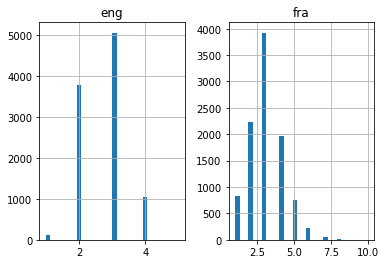

In [ ]:
#examine distribution of lengths
length_df_fra_sample.hist(bins=30)
plt.show()

In [ ]:
#prep english tokenizer for french translation
eng_fr_tokenizer = tokenization(fra_eng[:,0])
#get english vocab size for french translation
eng_fr_vocab_size = len(eng_fr_tokenizer.word_index)+1
eng_fr_length = max_length(fra_eng[:,0])
print("English vocabulary size: %d" % eng_fr_vocab_size)

English vocabulary size: 2064


In [ ]:
#prepare french tokenizer
fra_tokenizer = tokenization(fra_eng[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1

fra_length = max_length(fra_eng[:,1])
print('French Vocabulary Size: %d' % fra_vocab_size)

French Vocabulary Size: 4769


## French Baseline Model

In [ ]:
#Get training, test data
trainFra, testFra = train_test_split(fra_eng, test_size=0.2, random_state=12)

In [ ]:
#prepare training data
trainFrenchX = encode_sequences(fra_tokenizer, fra_length, trainFra[:,1])
trainEnglishFrenchY = encode_sequences(eng_fr_tokenizer, eng_fr_length, trainFra[:,0])

In [ ]:
#prepare test data
testFrenchX = encode_sequences(fra_tokenizer, fra_length, testFra[:,1])
testEnglishFrenchY=encode_sequences(eng_fr_tokenizer, eng_fr_length, testFra[:,0])

In [ ]:
#Build model
model_fr_1 = build_model1(fra_vocab_size, eng_fr_vocab_size, fra_length, eng_fr_length, 512)
model_fr_1.summary()
rms_fr_1 = optimizers.RMSprop(lr=0.001)
model_fr_1.compile(optimizer=rms_fr_1, loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 512)           2441728   
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 512)            2099200   
_________________________________________________________________
dense_10 (Dense)             (None, 5, 2064)           1058832   
Total params: 7,698,960
Trainable params: 7,698,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train French model
filename_fr_1 = 'model.h1.1_may_21_model1'
checkpoint_fr_1 = ModelCheckpoint(filename_fr_1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history_fr_1 = model_fr_1.fit(trainFrenchX, trainEnglishFrenchY.reshape(trainEnglishFrenchY.shape[0], trainEnglishFrenchY.shape[1],1),
                      epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoint_fr_1], verbose =1)

Epoch 1/30
13/13 [==============================] - 7s 167ms/step - loss: 6.1489 - accuracy: 0.3526 - val_loss: 3.9340 - val_accuracy: 0.4796

Epoch 00001: val_loss improved from inf to 3.93396, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 2/30
13/13 [==============================] - 1s 55ms/step - loss: 3.7393 - accuracy: 0.4862 - val_loss: 3.4403 - val_accuracy: 0.4985

Epoch 00002: val_loss improved from 3.93396 to 3.44032, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 3/30
13/13 [==============================] - 1s 55ms/step - loss: 3.3049 - accuracy: 0.4967 - val_loss: 3.2731 - val_accuracy: 0.5010

Epoch 00003: val_loss improved from 3.44032 to 3.27313, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 4/30
13/13 [==============================] - 1s 56ms/step - loss: 3.1393 - accuracy: 0.4993 - val_loss: 3.1813 - val_accuracy: 0.5025

Epoch 00004: val_loss improved from 3.27313 to 3.18134, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 5/30
13/13 [==============================] - 1s 55ms/step - loss: 3.0551 - accuracy: 0.5044 - val_loss: 3.1655 - val_accuracy: 0.5051

Epoch 00005: val_loss improved from 3.18134 to 3.16549, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 6/30
13/13 [==============================] - 1s 54ms/step - loss: 2.9842 - accuracy: 0.5065 - val_loss: 3.0916 - val_accuracy: 0.5079

Epoch 00006: val_loss improved from 3.16549 to 3.09158, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 7/30
13/13 [==============================] - 1s 56ms/step - loss: 2.9220 - accuracy: 0.5061 - val_loss: 3.0583 - val_accuracy: 0.5145

Epoch 00007: val_loss improved from 3.09158 to 3.05833, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 8/30
13/13 [==============================] - 1s 58ms/step - loss: 2.8557 - accuracy: 0.5128 - val_loss: 3.0281 - val_accuracy: 0.5131

Epoch 00008: val_loss improved from 3.05833 to 3.02808, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 9/30
13/13 [==============================] - 1s 55ms/step - loss: 2.8033 - accuracy: 0.5174 - val_loss: 3.0557 - val_accuracy: 0.5171

Epoch 00009: val_loss did not improve from 3.02808
Epoch 10/30
13/13 [==============================] - 1s 46ms/step - loss: 2.7824 - accuracy: 0.5281 - val_loss: 2.9171 - val_accuracy: 0.5428

Epoch 00010: val_loss improved from 3.02808 to 2.91714, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 11/30
13/13 [==============================] - 1s 57ms/step - loss: 2.6467 - accuracy: 0.5403 - val_loss: 2.8357 - val_accuracy: 0.5450

Epoch 00011: val_loss improved from 2.91714 to 2.83569, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 12/30
13/13 [==============================] - 1s 57ms/step - loss: 2.5483 - accuracy: 0.5501 - val_loss: 2.8114 - val_accuracy: 0.5526

Epoch 00012: val_loss improved from 2.83569 to 2.81145, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 13/30
13/13 [==============================] - 1s 54ms/step - loss: 2.4808 - accuracy: 0.5567 - val_loss: 2.7631 - val_accuracy: 0.5560

Epoch 00013: val_loss improved from 2.81145 to 2.76307, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 14/30
13/13 [==============================] - 1s 54ms/step - loss: 2.3723 - accuracy: 0.5698 - val_loss: 2.7110 - val_accuracy: 0.5726

Epoch 00014: val_loss improved from 2.76307 to 2.71104, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 15/30
13/13 [==============================] - 1s 54ms/step - loss: 2.3156 - accuracy: 0.5731 - val_loss: 2.6713 - val_accuracy: 0.5765

Epoch 00015: val_loss improved from 2.71104 to 2.67127, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 16/30
13/13 [==============================] - 1s 56ms/step - loss: 2.2305 - accuracy: 0.5863 - val_loss: 2.6247 - val_accuracy: 0.5809

Epoch 00016: val_loss improved from 2.67127 to 2.62472, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 17/30
13/13 [==============================] - 1s 57ms/step - loss: 2.1437 - accuracy: 0.5978 - val_loss: 2.6373 - val_accuracy: 0.5867

Epoch 00017: val_loss did not improve from 2.62472
Epoch 18/30
13/13 [==============================] - 1s 47ms/step - loss: 2.0926 - accuracy: 0.6061 - val_loss: 2.6386 - val_accuracy: 0.5911

Epoch 00018: val_loss did not improve from 2.62472
Epoch 19/30
13/13 [==============================] - 1s 46ms/step - loss: 2.0282 - accuracy: 0.6130 - val_loss: 2.5680 - val_accuracy: 0.5965

Epoch 00019: val_loss improved from 2.62472 to 2.56796, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 20/30
13/13 [==============================] - 1s 57ms/step - loss: 1.9469 - accuracy: 0.6216 - val_loss: 2.5027 - val_accuracy: 0.6094

Epoch 00020: val_loss improved from 2.56796 to 2.50267, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 21/30
13/13 [==============================] - 1s 55ms/step - loss: 1.8543 - accuracy: 0.6323 - val_loss: 2.4944 - val_accuracy: 0.6150

Epoch 00021: val_loss improved from 2.50267 to 2.49436, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 22/30
13/13 [==============================] - 1s 55ms/step - loss: 1.8178 - accuracy: 0.6367 - val_loss: 2.4395 - val_accuracy: 0.6180

Epoch 00022: val_loss improved from 2.49436 to 2.43953, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 23/30
13/13 [==============================] - 1s 53ms/step - loss: 1.7583 - accuracy: 0.6450 - val_loss: 2.4350 - val_accuracy: 0.6189

Epoch 00023: val_loss improved from 2.43953 to 2.43504, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 24/30
13/13 [==============================] - 1s 54ms/step - loss: 1.6806 - accuracy: 0.6545 - val_loss: 2.4321 - val_accuracy: 0.6208

Epoch 00024: val_loss improved from 2.43504 to 2.43209, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 25/30
13/13 [==============================] - 1s 56ms/step - loss: 1.6539 - accuracy: 0.6587 - val_loss: 2.4003 - val_accuracy: 0.6270

Epoch 00025: val_loss improved from 2.43209 to 2.40032, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 26/30
13/13 [==============================] - 1s 56ms/step - loss: 1.5851 - accuracy: 0.6663 - val_loss: 2.3796 - val_accuracy: 0.6325

Epoch 00026: val_loss improved from 2.40032 to 2.37960, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 27/30
13/13 [==============================] - 1s 56ms/step - loss: 1.5132 - accuracy: 0.6756 - val_loss: 2.3759 - val_accuracy: 0.6302

Epoch 00027: val_loss improved from 2.37960 to 2.37595, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 28/30
13/13 [==============================] - 1s 55ms/step - loss: 1.4739 - accuracy: 0.6823 - val_loss: 2.3464 - val_accuracy: 0.6382

Epoch 00028: val_loss improved from 2.37595 to 2.34640, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 29/30
13/13 [==============================] - 1s 57ms/step - loss: 1.4269 - accuracy: 0.6942 - val_loss: 2.3446 - val_accuracy: 0.6406

Epoch 00029: val_loss improved from 2.34640 to 2.34456, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


Epoch 30/30
13/13 [==============================] - 1s 55ms/step - loss: 1.3851 - accuracy: 0.6998 - val_loss: 2.3283 - val_accuracy: 0.6438

Epoch 00030: val_loss improved from 2.34456 to 2.32829, saving model to model.h1.1_may_21_model1


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


INFO:tensorflow:Assets written to: model.h1.1_may_21_model1/assets


In [ ]:
#Make predictions on test data
model_fr_pred_1 = load_model('model.h1.1_may_21_model1')
preds_fr_1 = model_fr_pred_1.predict_classes(testFrenchX.reshape(testFrenchX.shape[0], testFrenchX.shape[1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
#Convert predictions into text (English)
preds_text_eng_fr_1 = []
for i in preds_fr_1:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_fr_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_fr_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if (t == None):
                temp.append('')
            else:
                temp.append(t)
    preds_text_eng_fr_1.append(' '.join(temp))

In [ ]:
#Display first 15 predictions
pred_df_fr_1 = pd.DataFrame({'actual': testFra[:,0], 'predicted': preds_text_eng_fr_1})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df_fr_1.head(15)

,actual,predicted
0,tom is drunk,toms is
1,you seem busy,you are
2,im married,im exhausted
3,whos talking,who singing
4,eat your peas,the car
5,i had no idea,i have no
6,use them all,get to me
7,i am very tall,im am too
8,i have plans,i have the
9,i hurt tom,we loved tom


### French Baseline Model Metrics

In [ ]:
#Calculate French metrics: accuracy, precision, recall
y_pred_fr_1 = model_fr_1.predict_classes(testFrenchX, verbose=0)
print(y_pred_fr_1)
y_pred_fr_1 = argmax(y_pred_fr_1, axis=1)
print(y_pred_fr_1)
y_test_fr_1 = argmax(testEnglishFrenchY, axis=1)
print(y_test_fr_1)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_fr_1, y_pred_fr_1))
print("Precision:",metrics.precision_score(y_test_fr_1, y_pred_fr_1, average = "macro"))
print("Recall:",metrics.recall_score(y_test_fr_1, y_pred_fr_1, average = "macro"))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[ 53   7   0   0   0]
 [  4  14   0   0   0]
 [  5 528   0   0   0]
 ...
 [  9  16   8   0   0]
 [  3   7   0   0   0]
 [ 53   7   0   0   0]]
[0 1 1 ... 1 1 0]
[2 1 1 ... 1 2 2]
Accuracy: 0.5495
Precision: 0.5573137233071319
Recall: 0.446090777717565


In [ ]:
#Training accuracy
metricsModelFr1 = model_fr_1.evaluate(trainFrenchX, trainEnglishFrenchY, batch_size=512, return_dict=True)
print(metricsModelFr1)

16/16 [==============================] - 2s 18ms/step - loss: 1.5062 - accuracy: 0.6984
{'loss': 1.5061962604522705, 'accuracy': 0.6983749866485596}


In [ ]:
#Test accuracy
_, accuracy = model_fr_1.evaluate(testFrenchX, testEnglishFrenchY, batch_size=512)
print('Test accuracy: %.2f' % (accuracy*100))

4/4 [==============================] - 0s 16ms/step - loss: 2.3976 - accuracy: 0.6337
Test accuracy: 63.37


In [ ]:
# calculate bleu metric

references_fr_1 = pred_df_fr_1.actual
candidates_fr_1 = pred_df_fr_1.predicted
score_fr_1 = corpus_bleu(references_fr_1, candidates_fr_1, weights=(1,0,0,0))
print(score_fr_1)

0.4313206531491118


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
#average BLEU score
bleuScoreMeanFra1 = evaluate_test_model1(references_fr_1, candidates_fr_1)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Average BLEU score on test data for French model 1: ", bleuScoreMeanFra1)

Average BLEU score on test data for French model 1:  0.7745966692414834


In [ ]:
#Get ROUGE scores.
rouge = Rouge()
scores_fr_1 = rouge.get_scores(candidates_fr_1, references_fr_1, avg = True)
print(scores_fr_1)

{'rouge-1': {'f': 0.36350475847248254, 'p': 0.39470833333333366, 'r': 0.3452416666666672}, 'rouge-2': {'f': 0.1086499991485441, 'p': 0.12191666666666669, 'r': 0.10208333333333332}, 'rouge-l': {'f': 0.3630833299019095, 'p': 0.3946250000000004, 'r': 0.3446166666666673}}


## French Final Model

In [ ]:
#Model 2: An attempt at an encoder-decoder model. uses average BLEU as metric.
lines_fr = io.open(french_path, encoding = 'UTF-8').read().split('\n')

In [ ]:
#Get data
french, english_fr = get_data(lines_fr)
#get manageable sample
french = french[:10000:]
#get manageable sample
english_fr = english_fr[:10000:]
print(french[0:10])

100%|██████████| 185584/185584 [00:05<00:00, 33171.58it/s]

['<start> Va <end>', '<start> Marche. <end>', '<start> Bouge <end>', '<start> Salut <end>', '<start> Salut. <end>', '<start> Cours <end>', '<start> Courez <end>', '<start> Prenez vos jambes a vos cous <end>', '<start> File <end>', '<start> Filez <end>']


In [ ]:
#Get training, test data.
fra_tr, fra_te, eng_fr_tr, eng_fr_te = train_test_split(french, english_fr, test_size = 0.2, random_state = 42)

In [ ]:
#Tokenizing, padding input language
fra_token = Tokenizer(filters = '', lower=False)
fra_token.fit_on_texts(fra_tr)
fra_tokenized = fra_token.texts_to_sequences(fra_tr)
fra_padded = pad_sequences(fra_tokenized, padding='post')

In [ ]:
#tokenizing and padding target language
eng_fr_token = Tokenizer(filters = '', lower = False)
eng_fr_token.fit_on_texts(eng_fr_tr)
eng_fr_tokenized = eng_fr_token.texts_to_sequences(eng_fr_tr)
eng_fr_padded = pad_sequences(eng_fr_tokenized, padding='post')

In [ ]:
#Define maximum sentence length and vocab size.
num_ip_tokens = len(fra_token.word_index) #French
num_op_tokens = len(eng_fr_token.word_index) #English
max_len_ip = fra_padded.shape[1] #French
max_len_op = eng_fr_padded.shape[1] #English

In [ ]:
#Define constants and create a tf.data dataset.
BUFFER_SIZE = len(fra_padded)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE // BATCH_SIZE
embedding_dim = 256
units = 512

dataset_fr = tf.data.Dataset.from_tensor_slices((fra_padded, eng_fr_padded)).shuffle(BUFFER_SIZE)
dataset_fr = dataset_fr.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
#Create an encoder and a decoder for French.
encoder = Encoder(num_ip_tokens + 1, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(num_op_tokens + 1, embedding_dim, units, BATCH_SIZE)

In [ ]:
#define an optimizer and a loss function for French
optimizer_fr = tf.keras.optimizers.Adam()

def loss_function_fr(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred)*mask
  return tf.reduce_mean(loss_)
#Define checkpoints
checkpoint_dir_fr = '/content/drive/MyDrive/FrenchToEnglish/CheckPoint'
checkpoint_prefix_fr = os.path.join(checkpoint_dir_fr, 'ckpt')
checkpoint_fr = Checkpoint(optimizer=optimizer_fr, encoder=encoder, decoder=decoder)

In [ ]:
#Train model
EPOCH = 20
for epoch in range(EPOCH) :
  start = time.time()
  #Getting initial encoder states (all zeros)
  hidden = encoder.initial_hidden_state()
  total_loss = 0
  for (batch, (inp, targ)) in enumerate(dataset_fr) :
    loss = 0
    with tf.GradientTape() as tape :
      enc_output , enc_hidden = encoder(inp, hidden)
      #Setting final encoder states as initial decoder states
      dec_hidden = enc_hidden
      # Teacher forcing - feeding the target as the next input
      #Passing '<start>' token as initial token
      dec_input = tf.expand_dims([eng_token.word_index['<start>']]*BATCH_SIZE, 1)
      for t in range(1, targ.shape[1]) :
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function_fr(targ[:,t], predictions)
        # using teacher forcing
        dec_input = tf.expand_dims(targ[:,t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    total_loss += batch_loss        
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)
    optimizer_fr.apply_gradients(zip(gradients, variables))
    if batch % 1000 == 0 :
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
    # saving (checkpoint)  the model every 2 epochs
  if (epoch + 1)%2 == 0 :
    checkpoint_fr.save(file_prefix=checkpoint_prefix_fr)
  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
  print('Time taken for 1 epoch {0:0.2f} minutes\n'.format((time.time() - start)/60))

Epoch 1 Batch 0 Loss 4.0636
Epoch 1 Loss 2.6157
Time taken for 1 epoch 0.31 minutes

Epoch 2 Batch 0 Loss 2.0949
Epoch 2 Loss 2.0001
Time taken for 1 epoch 0.30 minutes

Epoch 3 Batch 0 Loss 1.7358
Epoch 3 Loss 1.7399
Time taken for 1 epoch 0.30 minutes

Epoch 4 Batch 0 Loss 1.5766
Epoch 4 Loss 1.5366
Time taken for 1 epoch 0.31 minutes

Epoch 5 Batch 0 Loss 1.3452
Epoch 5 Loss 1.3378
Time taken for 1 epoch 0.31 minutes

Epoch 6 Batch 0 Loss 1.1505
Epoch 6 Loss 1.1654
Time taken for 1 epoch 0.32 minutes

Epoch 7 Batch 0 Loss 0.9666
Epoch 7 Loss 1.0049
Time taken for 1 epoch 0.32 minutes

Epoch 8 Batch 0 Loss 0.8352
Epoch 8 Loss 0.8592
Time taken for 1 epoch 0.30 minutes

Epoch 9 Batch 0 Loss 0.6958
Epoch 9 Loss 0.7297
Time taken for 1 epoch 0.30 minutes

Epoch 10 Batch 0 Loss 0.5479
Epoch 10 Loss 0.6082
Time taken for 1 epoch 0.30 minutes

Epoch 11 Batch 0 Loss 0.4149
Epoch 11 Loss 0.4983
Time taken for 1 epoch 0.30 minutes

Epoch 12 Batch 0 Loss 0.4136
Epoch 12 Loss 0.4089
Time taken 

### French Final Model Metrics

In [ ]:
#Get average BLEU score
bleuScoreMeanFra, referencesFr2, hypothesesFr2 = evaluate_test_model2(fra_te, eng_fr_te, encoder, decoder, fra_token, eng_fr_token, max_len_ip, max_len_op)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Average BLEU score on test data for French model 2: ", bleuScoreMeanFra)

Average BLEU score on test data for French model 2:  0.7545756661354549


In [ ]:
#Get ROUGE scores.
rouge = Rouge()
scores_fr_2 = rouge.get_scores(hypothesesFr2, referencesFr2, avg = True)
print(scores_fr_2)

{'rouge-1': {'f': 0.15868719131066544, 'p': 0.21183333333333298, 'r': 0.12837499999999946}, 'rouge-2': {'f': 0.05693452320397745, 'p': 0.08837500000000001, 'r': 0.04283333333333336}, 'rouge-l': {'f': 0.15896630386817281, 'p': 0.2131333333333329, 'r': 0.12830833333333277}}
